##PERSIAPAN LIBRARY

In [1]:
!pip install Transformers

In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00


In [3]:
import os
import tensorflow as tf
import keras
import re
import pandas as pd
import numpy as np
import sklearn
import torch
import pickle
import matplotlib.pyplot as plt

In [4]:
from tensorflow.keras.layers import MultiHeadAttention, Input, Dense
from tensorflow.keras.layers import LayerNormalization, Layer
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D

from tensorflow.data import Dataset
from tensorflow import convert_to_tensor, string, float32, shape, range, reshape
from tensorflow.keras import utils

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, Reshape

from sklearn.utils.class_weight import compute_class_weight

from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from transformers import BertTokenizer, TFBertForSequenceClassification, Trainer, TrainingArguments
from evaluate import load

from imblearn.over_sampling import SMOTE

##PERSIAPAN DATASET (MOUNT GDRIVE)

In [5]:
df_train = pd.read_excel("/content/drive/MyDrive/BPS_PROJECT/PRE-PROCESSED/labeled.xlsx")

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670 entries, 0 to 1669
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   placeId              1550 non-null   object 
 1   placeName            1670 non-null   object 
 2   placeAddress         1647 non-null   object 
 3   placeBusinessStatus  1670 non-null   object 
 4   placeTypes           1670 non-null   object 
 5   placeLatitude        1669 non-null   float64
 6   placeLongitude       1669 non-null   float64
 7   kbli                 1670 non-null   object 
dtypes: float64(2), object(6)
memory usage: 104.5+ KB


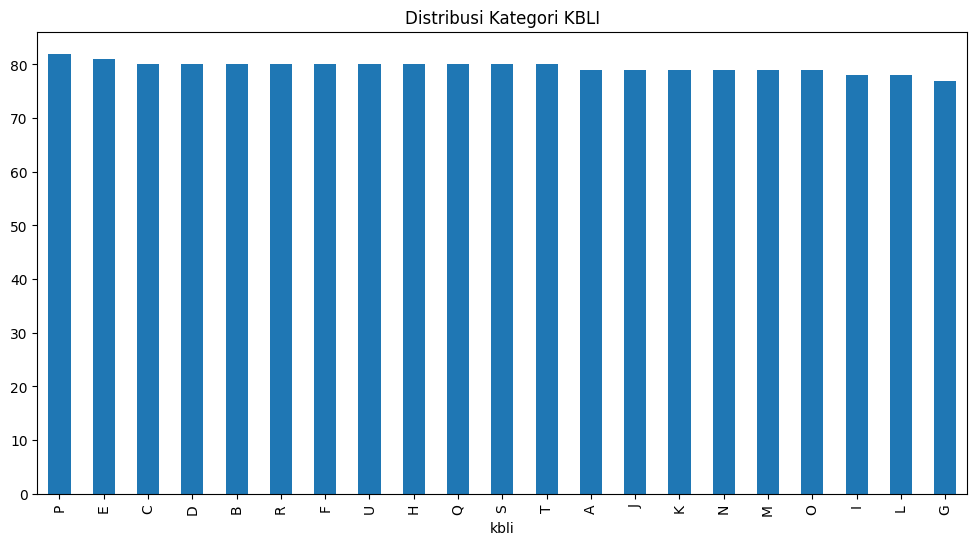

In [7]:
class_distribution = df_train['kbli'].value_counts()

plt.figure(figsize=(12,6))
class_distribution.plot(kind='bar')
plt.title("Distribusi Kategori KBLI")
plt.show()

In [8]:
class_counts = df_train['kbli'].value_counts()
print("Jumlah sampel per kelas:\n", class_counts)

Jumlah sampel per kelas:
 kbli
P    82
E    81
C    80
D    80
B    80
R    80
F    80
U    80
H    80
Q    80
S    80
T    80
A    79
J    79
K    79
N    79
M    79
O    79
I    78
L    78
G    77
Name: count, dtype: int64


In [9]:
df_train['placeAddress']=df_train['placeAddress'].fillna('-')

In [10]:
df_train['desc'] = df_train['placeName'] + df_train['placeTypes']

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_train['desc'] = df_train['desc'].apply(clean_text)

In [12]:
tfidf = TfidfVectorizer(max_features=2000)
X = tfidf.fit_transform(df_train['desc'])
y = df_train['kbli']

##SPLIT DATASET (TRAIN, TEST, VAL)

In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

In [14]:
smote = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [15]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

X_train_float = X_train.toarray().astype('float32')
X_val_float = X_val.toarray().astype('float32')

##MODEL

In [16]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            accuracy = logs.get('accuracy')
            val_accuracy = logs.get('val_accuracy')
            if accuracy is not None and val_accuracy is not None:
                if accuracy >= 0.90 and val_accuracy >= 0.80:
                    self.model.stop_training = True
                    print("\nReached 90% train accuracy and 80% validation accuracy, so cancelling training!")

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('se_with_cnn.keras', save_best_only=True, monitor='val_accuracy', mode='max')

In [18]:
early_stopping = EarlyStoppingCallback()

### CNN

In [19]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weights = dict(enumerate(class_weights))

In [20]:
model_cnn = Sequential([
    # Reshape((X_train_float.shape[1], 1), input_shape=(X_train_float.shape[1],)),
    # Conv1D(filters=64, kernel_size=3, activation='relu'),
    # Flatten(),
    # Dense(256, activation='relu'),
    # Dropout(0.5),
    # Dense(128, activation='relu'),
    # Dense(21, activation='softmax')

    Reshape((X_train_float.shape[1], 1), input_shape=(X_train_float.shape[1],)),
    Conv1D(32, 3, activation='relu'),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(21, activation='softmax')
])
model_cnn.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_cnn = model_cnn.fit(
    X_train_float, y_train_encoded,
    validation_data = (X_val_float, y_val_encoded),
    epochs = 20,
    batch_size = 32,
    class_weight=class_weights
    # callbacks=[early_stopping, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 221ms/step - accuracy: 0.1982 - loss: 3.0748 - val_accuracy: 0.6228 - val_loss: 2.8454
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5651 - loss: 2.7414 - val_accuracy: 0.8204 - val_loss: 2.4704
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6807 - loss: 2.3276 - val_accuracy: 0.8802 - val_loss: 2.0488
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8004 - loss: 1.8753 - val_accuracy: 0.8922 - val_loss: 1.7104
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8404 - loss: 1.5766 - val_accuracy: 0.8982 - val_loss: 1.4600
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9105 - loss: 1.2934 - val_accuracy: 0.9162 - val_loss: 1.2861
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9143 - loss: 1.1535 - val_accuracy: 0.9162 - val_loss: 1.1798
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9360 - loss: 1.0517 - val_accuracy: 0.9341 - val_lo

#HASIL TRAINING

##CNN

In [21]:
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 2000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1998, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 63936)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,091,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 21)             │         1,365 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,280,385 (46.85 MB)

 Trainable params: 4,093,461 (15.62 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,186,924 (31.23 MB)

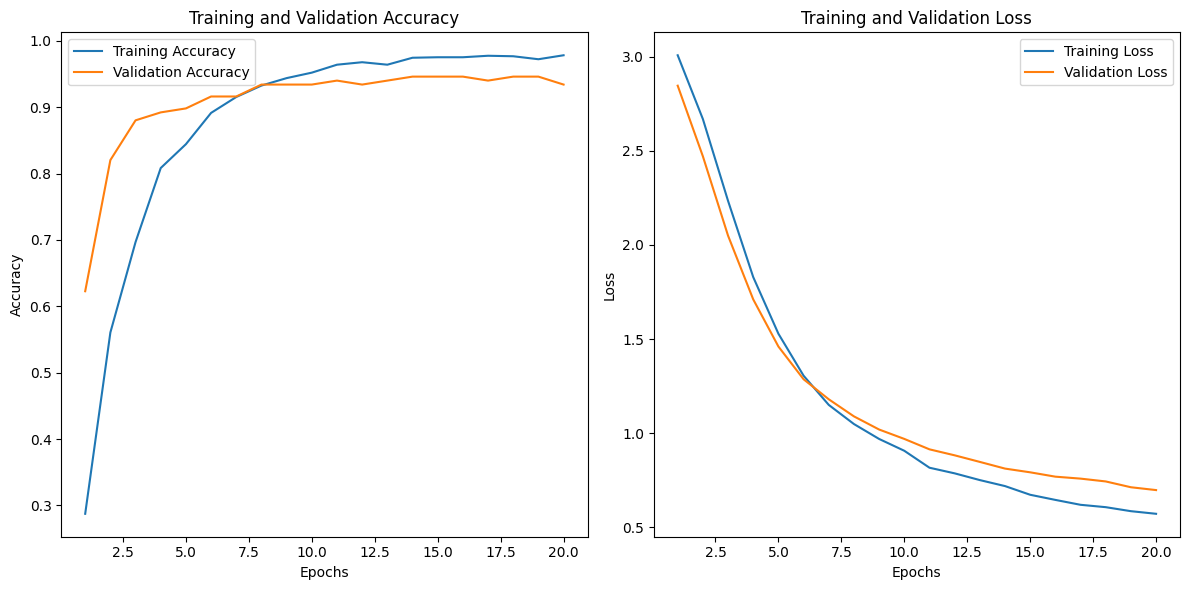

In [22]:
accuracy = history_cnn.history['accuracy']
val_accuracy = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


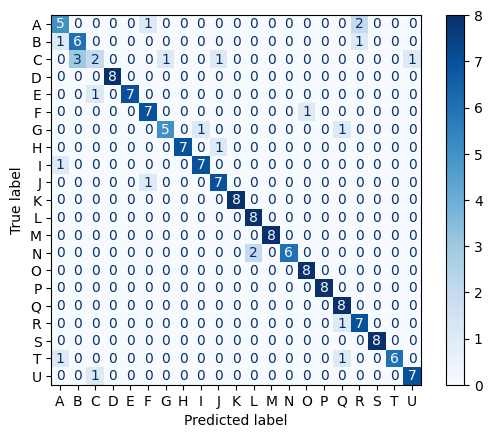

In [23]:
y_test_encoded = le.transform(y_test)
y_pred = model_cnn.predict(X_test.toarray()).argmax(axis=1)
cm = confusion_matrix(y_test_encoded, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.show()

In [24]:
X_test_float = X_test.toarray().astype('float32')
y_test_encoded = le.transform(y_test)

y_pred_prob = model_cnn.predict(X_test_float)
y_pred = y_pred_prob.argmax(axis=1)

f1 = f1_score(y_test_encoded, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
F1 Score: 0.8510

Classification Report:
              precision    recall  f1-score   support

           A       0.62      0.62      0.62         8
           B       0.67      0.75      0.71         8
           C       0.50      0.25      0.33         8
           D       1.00      1.00      1.00         8
           E       1.00      0.88      0.93         8
           F       0.78      0.88      0.82         8
           G       0.83      0.71      0.77         7
           H       1.00      0.88      0.93         8
           I       0.88      0.88      0.88         8
           J       0.78      0.88      0.82         8
           K       1.00      1.00      1.00         8
           L       0.80      1.00      0.89         8
           M       1.00      1.00      1.00         8
           N       1.00      0.75      0.86         8
           O       0.89      1.00      0.94         8
           P       1.00      1.00      1.00         8
  

In [25]:
X_test_float = X_test.toarray().astype('float32')
y_test_encoded = le.transform(y_test)

y_pred_probs = model_cnn.predict(X_test_float)
y_pred = y_pred_probs.argmax(axis=1)
confidence = y_pred_probs.max(axis=1)

results_df = pd.DataFrame({
    'original_label': le.inverse_transform(y_test_encoded),
    'predicted_label': le.inverse_transform(y_pred),
    'confidence': confidence
})

results_df.to_excel("test_predictions_cnn.xlsx", index=False)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


#Simpan Model (.h5 dan .savetensor)

In [26]:
model_cnn.save('/content/drive/MyDrive/BPS_PROJECT/MODEL/klbi_classification/klbi_class_cnn.keras')
model_cnn.save('/content/drive/MyDrive/BPS_PROJECT/MODEL/klbi_classification/klbi_class_cnn.h5')

In [27]:
with open("/content/drive/MyDrive/BPS_PROJECT/MODEL/klbi_classification/tfidf_vectorizer_cnn.pkl", "wb") as f:
    pickle.dump(tfidf, f)

#Apply Model Ke Dataset Full

In [28]:
df = pd.read_excel("/content/drive/MyDrive/BPS_PROJECT/PROCESSED/klbi_classification/final_data.xlsx")

### CNN

In [29]:
model_cnn = load_model('/content/drive/MyDrive/BPS_PROJECT/MODEL/klbi_classification/klbi_class_cnn.h5')

In [30]:
with open("/content/drive/MyDrive/BPS_PROJECT/MODEL/klbi_classification/tfidf_vectorizer_cnn.pkl", "rb") as f:
    tfidf = pickle.load(f)

In [31]:
X_new = tfidf.transform(df['placeName'] + df['placeTypes'])
X_new_float = X_new.toarray().astype('float32')

In [32]:
y_new_probs = model_cnn.predict(X_new_float)
y_new_pred = y_new_probs.argmax(axis=1)

1245/1245 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


In [33]:
df['predicted_label'] = le.inverse_transform(y_new_pred)

In [34]:
df.to_excel("//content/drive/MyDrive/BPS_PROJECT/PROCESSED/klbi_classification/PREDICTED_ALL_82ACC_cnn.xlsx", index = False)

In [35]:
df.head(20)

,placeId,placeName,placeAddress,placeBusinessStatus,placeTypes,placeLatitude,placeLongitude,source,predicted_label
0,ChIJG0i9CEap1TERq1G-K3lxuus,Graha Renova,GC2C+GP3 Tengkerang Barat,OPERATIONAL,point_of_interest establishment,0.501254,101.421803,GMAPS,I
1,ChIJI0kxnE-p1TERVzzCaVLc_-A,Putri Jaya Abadi CV,Jalan Musyawarah No 184 Labuh Baru Timur,OPERATIONAL,furniture_store home_goods_store point_of_inte...,0.503969,101.423609,GMAPS,G
2,ChIJ75xs3BSp1TERjUD6T2Hr7MU,Warung Ojo Forget,GC3G+GQ4 Jalan Soekarno-Hatta Sidomulyo Timur,OPERATIONAL,restaurant point_of_interest food establishment,0.503770,101.426964,GMAPS,I
3,ChIJn_QB002p1TERjXQjpmobcjE,Batam Central Electronik,Komplek Taman Anggrek Blok A4-6 Jl Tuanku Tamb...,OPERATIONAL,electronics_store point_of_interest store esta...,0.503697,101.428838,GMAPS,G
4,ChIJWxkAUdOp1TERTPhwfB11yBc,BOS Bintang Oto Service,Jalan Ikhlas Labuh Baru Timur,OPERATIONAL,car_repair point_of_interest establishment,0.505233,101.430264,GMAPS,P
5,ChIJGZ6fZWKp1TER1-ehi3TTs-M,Arjuna 51,GC6F+7GC Labuh Baru Timur,OPERATIONAL,lodging point_of_interest establishment,0.510688,101.423754,GMAPS,L
6,ChIJ7z8NCnmp1TERBB6h6lgxpGk,Villa Garuda Mas C3 Mawar,Villa Jalan Garuda Mas Mawar No C3 Labuh Baru ...,OPERATIONAL,point_of_interest establishment,0.510855,101.425538,GMAPS,L
7,ChIJuwVlnjir1TERIrSo4VY6KJk,Laundry Sepatu Hotel Shoes Clean treatment,Jalan Arjuna No 125,OPERATIONAL,point_of_interest establishment,0.508483,101.424036,GMAPS,S
8,ChIJ0cJza2mp1TERIuIVdKGyDS0,Vape Pink Store,Jalan Eka Sari Jalan Arjuna No 56 Labuh Baru T...,OPERATIONAL,point_of_interest store establishment,0.511309,101.424465,GMAPS,G
9,ChIJV698pw2p1TERYF4aEyoypYg,Bengkel Las Arjuna,GC6F+GQG Jalan Arjuna Labuh Baru Timur,OPERATIONAL,point_of_interest establishment,0.511312,101.424466,GMAPS,G


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39833 entries, 0 to 39832
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   placeId              39833 non-null  object 
 1   placeName            39833 non-null  object 
 2   placeAddress         39833 non-null  object 
 3   placeBusinessStatus  39833 non-null  object 
 4   placeTypes           39833 non-null  object 
 5   placeLatitude        39833 non-null  float64
 6   placeLongitude       39833 non-null  float64
 7   source               39833 non-null  object 
 8   predicted_label      39833 non-null  object 
dtypes: float64(2), object(7)
memory usage: 2.7+ MB


#VISUALISASI

<ipython-input-37-70c571d7a356>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=predicted_label_counts.index, y=predicted_label_counts.values, palette='viridis')


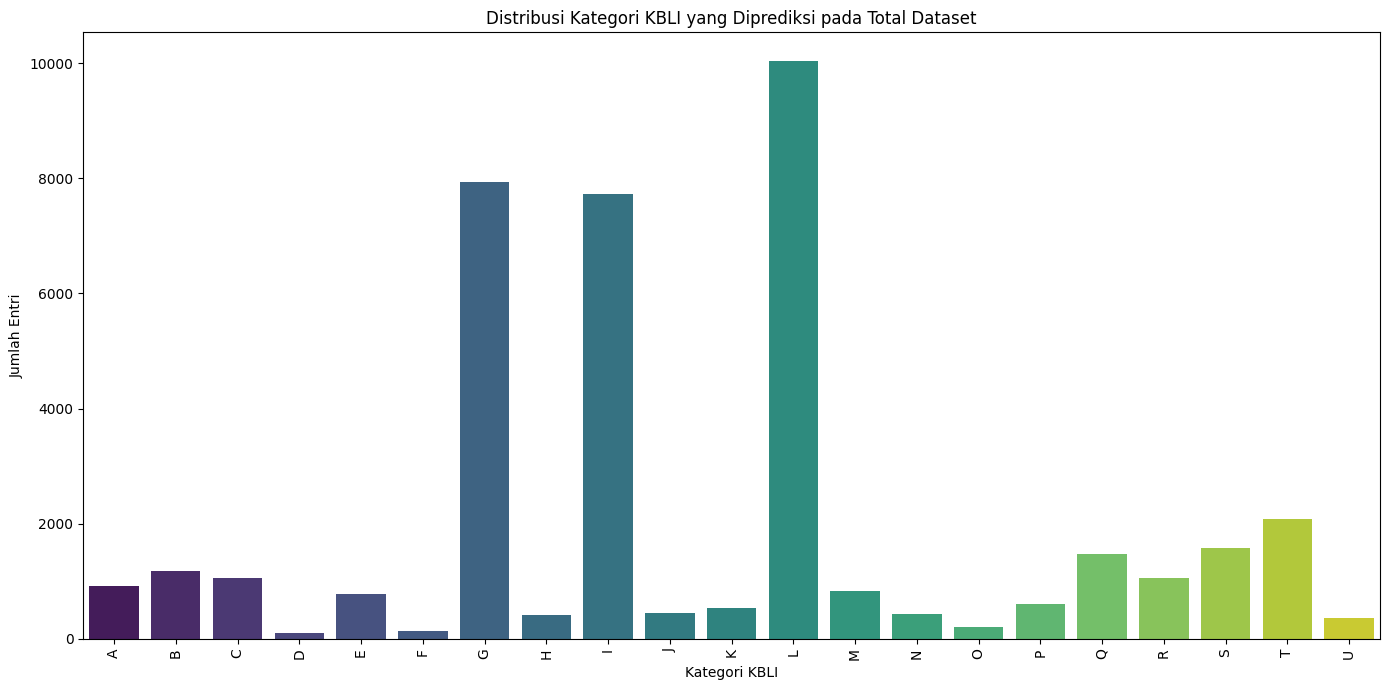


Jumlah total entri per kategori KBLI yang diprediksi:
predicted_label
A      911
B     1174
C     1064
D      103
E      778
F      128
G     7930
H      406
I     7733
J      439
K      526
L    10037
M      828
N      432
O      208
P      606
Q     1469
R     1052
S     1579
T     2076
U      354
Name: count, dtype: int64


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

predicted_label_counts = df['predicted_label'].value_counts().sort_index()

plt.figure(figsize=(14, 7))
sns.barplot(x=predicted_label_counts.index, y=predicted_label_counts.values, palette='viridis')
plt.title('Distribusi Kategori KBLI yang Diprediksi pada Total Dataset')
plt.xlabel('Kategori KBLI')
plt.ylabel('Jumlah Entri')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print("\nJumlah total entri per kategori KBLI yang diprediksi:")
print(predicted_label_counts)

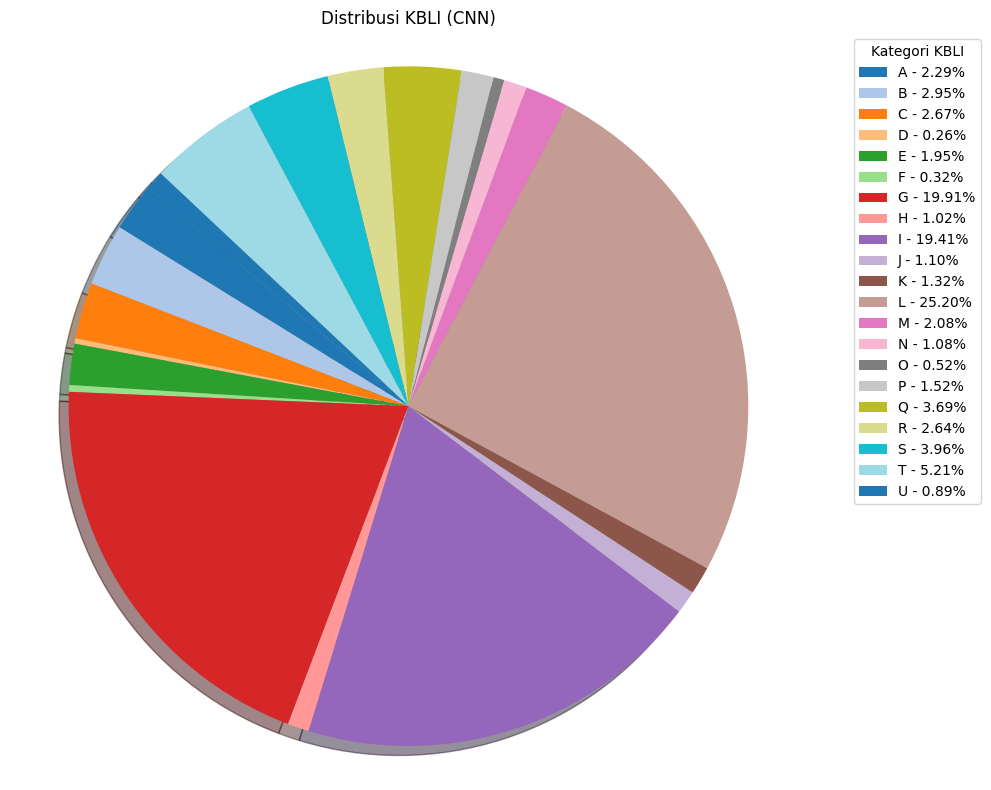

In [42]:
predicted_label_counts = df['predicted_label'].value_counts().sort_index()
total = predicted_label_counts.sum()
colors = plt.get_cmap('tab20').colors

percentages = [f"{label} - {value/total*100:.2f}%" for label, value in zip(predicted_label_counts.index, predicted_label_counts.values)]

plt.figure(figsize=(10, 8))
patches, _ = plt.pie(
    predicted_label_counts.values,
    startangle=140,
    shadow=True,
    colors=colors
)

plt.legend(patches, percentages, title="Kategori KBLI", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title('Distribusi KBLI (CNN)')
plt.axis('equal')
plt.tight_layout()
plt.show()


<ipython-input-39-5a2da68300ee>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f1_scores_series.index, y=f1_scores_series.values, palette='coolwarm')


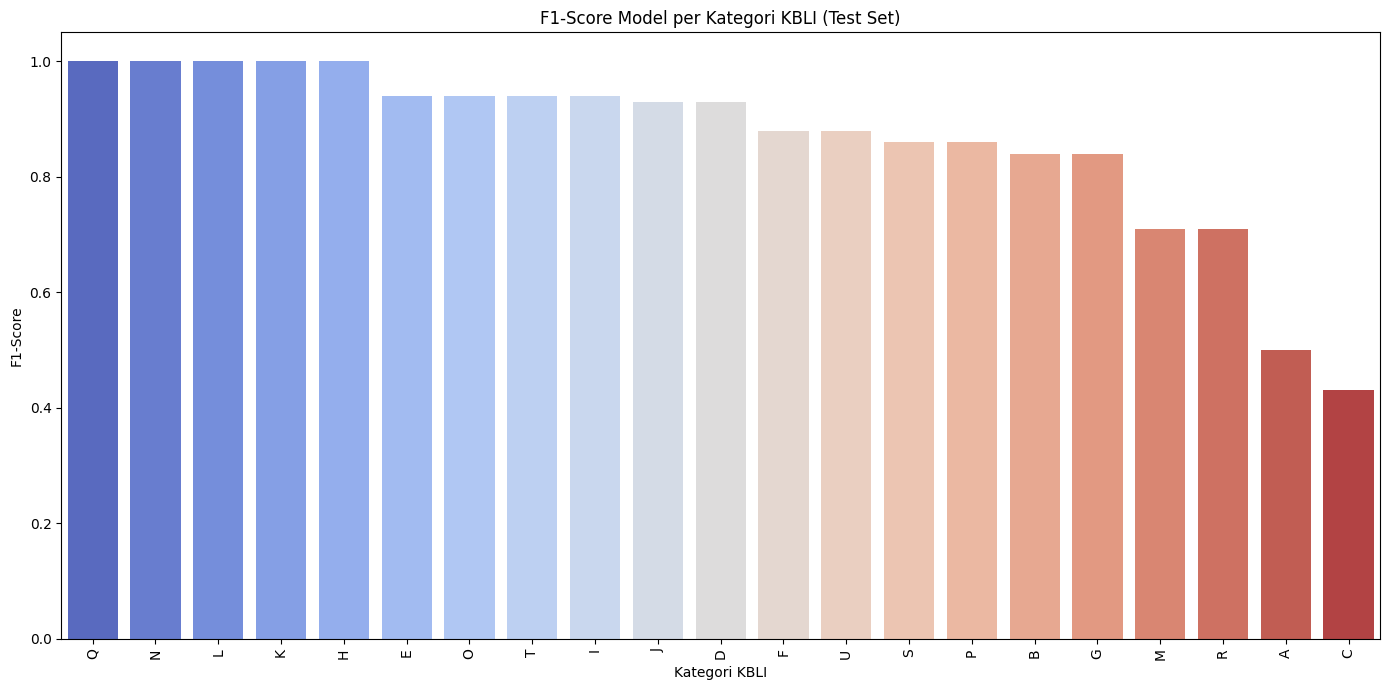

In [39]:
report_data = {
    'A': {'precision': 0.75, 'recall': 0.38, 'f1-score': 0.50, 'support': 8},
    'B': {'precision': 0.73, 'recall': 1.00, 'f1-score': 0.84, 'support': 8},
    'C': {'precision': 0.50, 'recall': 0.38, 'f1-score': 0.43, 'support': 8},
    'D': {'precision': 1.00, 'recall': 0.88, 'f1-score': 0.93, 'support': 8},
    'E': {'precision': 0.89, 'recall': 1.00, 'f1-score': 0.94, 'support': 8},
    'F': {'precision': 0.88, 'recall': 0.88, 'f1-score': 0.88, 'support': 8},
    'G': {'precision': 0.73, 'recall': 1.00, 'f1-score': 0.84, 'support': 8},
    'H': {'precision': 1.00, 'recall': 1.00, 'f1-score': 1.00, 'support': 8},
    'I': {'precision': 0.89, 'recall': 1.00, 'f1-score': 0.94, 'support': 8},
    'J': {'precision': 1.00, 'recall': 0.88, 'f1-score': 0.93, 'support': 8},
    'K': {'precision': 1.00, 'recall': 1.00, 'f1-score': 1.00, 'support': 8},
    'L': {'precision': 1.00, 'recall': 1.00, 'f1-score': 1.00, 'support': 7},
    'M': {'precision': 0.67, 'recall': 0.75, 'f1-score': 0.71, 'support': 8},
    'N': {'precision': 1.00, 'recall': 1.00, 'f1-score': 1.00, 'support': 8},
    'O': {'precision': 0.89, 'recall': 1.00, 'f1-score': 0.94, 'support': 8},
    'P': {'precision': 1.00, 'recall': 0.75, 'f1-score': 0.86, 'support': 8},
    'Q': {'precision': 1.00, 'recall': 1.00, 'f1-score': 1.00, 'support': 8},
    'R': {'precision': 0.67, 'recall': 0.75, 'f1-score': 0.71, 'support': 8},
    'S': {'precision': 1.00, 'recall': 0.75, 'f1-score': 0.86, 'support': 8},
    'T': {'precision': 0.89, 'recall': 1.00, 'f1-score': 0.94, 'support': 8},
    'U': {'precision': 0.88, 'recall': 0.88, 'f1-score': 0.88, 'support': 8},
}

f1_scores = {label: metrics['f1-score'] for label, metrics in report_data.items()}

f1_scores_series = pd.Series(f1_scores).sort_values(ascending=False)

plt.figure(figsize=(14, 7))
sns.barplot(x=f1_scores_series.index, y=f1_scores_series.values, palette='coolwarm')
plt.title('F1-Score Model per Kategori KBLI (Test Set)')
plt.xlabel('Kategori KBLI')
plt.ylabel('F1-Score')
plt.ylim(0, 1.05)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()